In [134]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, MultiLabelBinarizer, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, matthews_corrcoef, cohen_kappa_score, classification_report, make_scorer
)
from sklearn.ensemble import (
    HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier
)
from sklearn.model_selection import cross_val_score, cross_validate
import dill
import os
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint, uniform


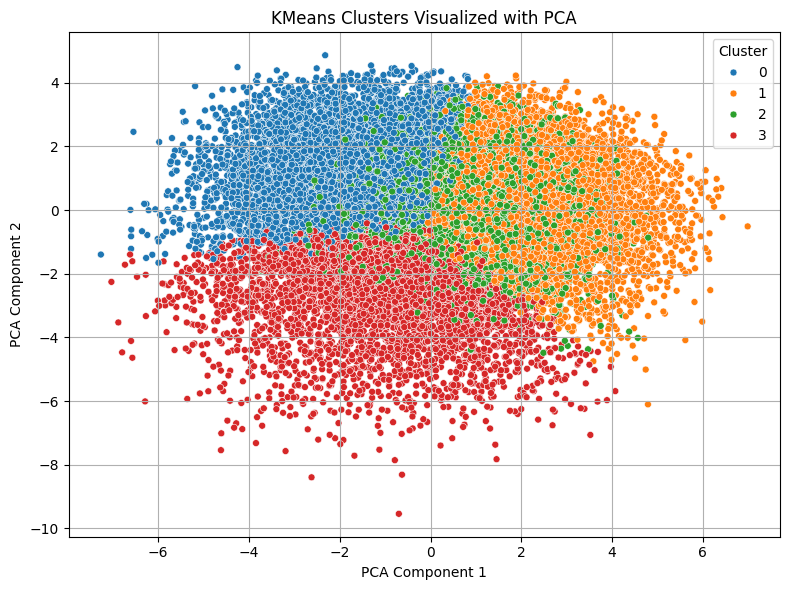

In [135]:
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Company = pd.read_csv("Company.csv")
satisfy = Company.copy()
fulfill = Company.copy()

satisfy = satisfy[[column for column in satisfy.columns if column != "q61"] + ["q61"]]  
fulfill = fulfill[[column for column in fulfill.columns if column != "q62"] + ["q62"]] 
# Split with stratification
satisfy_train, satisfy_test = train_test_split(
    satisfy, test_size=0.2, random_state=42, stratify=satisfy["q61"]
)

fulfill_train, fulfill_test = train_test_split(
    fulfill, test_size=0.2, random_state=42, stratify=fulfill["q62"]
)
 

df = satisfy_train

df["form_start"] = pd.to_datetime(df["form_start"])
df["form_end"] = pd.to_datetime(df["form_end"])
df["duration"] = (df["form_end"] - df["form_start"]).dt.total_seconds()

# df = df[df["duration"] >= 300]
# Convert multiselect object columns to sets of ints
multi_cols = ["q63", "q64", "q65", "q66", "q67", "q73", "q74"]
df_multi = df.copy()
for col in multi_cols:
    df_multi[col] = df_multi[col].apply(lambda x: list(map(int, str(x).split(","))))

# Apply MultiLabelBinarizer to multiselect columns
mlb = MultiLabelBinarizer()
multi_encoded = pd.DataFrame()

for col in multi_cols:
    transformed = pd.DataFrame(mlb.fit_transform(df_multi[col]), columns=[f"{col}_{cls}" for cls in mlb.classes_])
    multi_encoded = pd.concat([multi_encoded, transformed], axis=1)

# Select numeric + one-hot-ready columns
numerics = df.drop(columns=multi_cols + ["form_start", "form_end"]).select_dtypes(include="number")

# Combine everything
X_cluster = pd.concat([numerics.reset_index(drop=True), multi_encoded.reset_index(drop=True)], axis=1)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# X_pca = X_scaled 
# Cluster using KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Attach cluster labels for analysis
df["cluster"] = clusters
df["cluster_pca1"] = X_pca[:, 0]
df["cluster_pca2"] = X_pca[:, 1]

# Plot clusters in PCA-reduced space
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="cluster_pca1", y="cluster_pca2", hue="cluster", palette="tab10", s=25)
plt.title("KMeans Clusters Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()




In [158]:
# Value counts of q61 responses by cluster
q61_counts = df.groupby("cluster")["q61"].value_counts().unstack(fill_value=0)

# Value counts of q62 responses by cluster
q62_counts = df.groupby("cluster")["q62"].value_counts().unstack(fill_value=0)

# Show results
print("q61 counts per cluster:\n", q61_counts)
print("\nq62 counts per cluster:\n", q62_counts)


q61 counts per cluster:
 q61      -100  -33    33    100
cluster                        
0         282  1224  4720  1020
1          28   190  2845  3216
2          15   112  2228  3190
3         225   701  2852   991

q62 counts per cluster:
 q62      -100  -33    33    100
cluster                        
0         584  1211  3272  2179
1         114   325  1766  4074
2          60   168  1329  3988
3         404   773  1983  1609


In [157]:
df.groupby("cluster")[["q61", "q62"]].describe()


q61                                                          \
          count       mean        std    min   25%    50%    75%    max   
cluster                                                                   
0        7246.0  26.106542  44.820775 -100.0  33.0   33.0   33.0  100.0   
1        6279.0  64.726071  38.776010 -100.0  33.0  100.0  100.0  100.0   
2        5545.0  69.851758  36.885216 -100.0  33.0  100.0  100.0  100.0   
3        4769.0  30.946320  49.030163 -100.0  33.0   33.0   33.0  100.0   

            q62                                                          
          count       mean        std    min   25%    50%    75%    max  
cluster                                                                  
0        7246.0  31.398427  59.173555 -100.0  33.0   33.0  100.0  100.0  
1        6279.0  70.640707  45.196469 -100.0  33.0  100.0  100.0  100.0  
2        5545.0  77.748061  39.367366 -100.0  33.0  100.0  100.0  100.0  
3        4769.0  33.640176  60.987385 -100.0  33.0   33.0  100.0  100.0

In [137]:
df.head()

,form_end,form_start,q01,q02,q03,q04,q05,q06,q07,q08,...,q70,q71,q72,q73,q74,q61,duration,cluster,cluster_pca1,cluster_pca2
11430,2021-05-27 18:36:05,2021-05-27 18:22:06,1,2,2,1,1,1,2,2,...,5,2,1,3,2,33,839.0,0,-2.619986,1.232797
13670,2021-05-28 09:47:11,2021-05-28 09:41:36,2,2,1,2,1,1,2,2,...,6,2,1,3,5,33,335.0,0,-3.947707,3.226651
26291,2021-05-28 12:11:31,2021-05-28 11:49:05,2,1,1,2,2,2,1,2,...,5,2,2,2,4,33,1346.0,3,-1.007730,-4.427742
17064,2021-05-26 07:08:28,2021-05-26 06:45:53,1,2,1,1,1,1,1,2,...,5,2,2,2,"1,4",100,1355.0,1,3.459304,1.773820
17032,2021-05-28 08:25:28,2021-05-28 08:14:32,1,2,1,1,1,1,2,2,...,6,2,1,6,3,100,656.0,1,1.427574,3.573980


## Describing Gender per Cluster 

In [138]:
df.groupby("cluster")["q71"].describe()


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,7246.0,1.934171,0.248001,1.0,2.0,2.0,2.0,2.0
1,6279.0,1.870999,0.335228,1.0,2.0,2.0,2.0,2.0
2,5545.0,1.924076,0.264901,1.0,2.0,2.0,2.0,2.0
3,4769.0,1.895366,0.306113,1.0,2.0,2.0,2.0,2.0


In [159]:
df[df["q71"] == 1].groupby("cluster")[["q61", "q62"]].describe()


q61                                                            q62  \
         count       mean        std    min   25%    50%    75%    max  count   
cluster                                                                         
0        477.0   7.660377  50.113966 -100.0 -33.0   33.0   33.0  100.0  477.0   
1        810.0  58.783951  41.437000 -100.0  33.0   33.0  100.0  100.0  810.0   
2        421.0  66.627078  40.345663 -100.0  33.0  100.0  100.0  100.0  421.0   
3        499.0  16.779559  53.039119 -100.0 -33.0   33.0   33.0  100.0  499.0   

                                                                 
              mean        std    min   25%    50%    75%    max  
cluster                                                          
0        11.767296  62.533036 -100.0 -33.0   33.0   33.0  100.0  
1        60.330864  51.643632 -100.0  33.0  100.0  100.0  100.0  
2        69.358670  48.566421 -100.0  33.0  100.0  100.0  100.0  
3        18.306613  63.902946 -100.0 -33.0   33.0   33.0  100.0

,q61,q62
cluster,,
0,27.406412,32.781799
1,65.606144,72.167672
2,70.116706,78.437354
3,32.601874,35.432084


## Duration

In [141]:
df.groupby("cluster")["duration"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,7246.0,6637.222882,114010.287606,48.0,392.0,552.5,883.0,8606730.0
1,6279.0,4918.476987,33752.726511,38.0,389.0,555.0,897.0,1900334.0
2,5545.0,8965.816231,173659.862279,82.0,423.0,624.0,1043.0,11284688.0
3,4769.0,6161.786538,44115.082235,38.0,364.0,523.0,864.0,1650948.0


## Marital Status

In [142]:
df.groupby("cluster")["q72"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,7246.0,1.640767,0.479809,1.0,1.0,2.0,2.0,2.0
1,6279.0,1.646281,0.478161,1.0,1.0,2.0,2.0,2.0
2,5545.0,1.534175,0.498876,1.0,1.0,2.0,2.0,2.0
3,4769.0,1.486895,0.499881,1.0,1.0,1.0,2.0,2.0


In [160]:
 df.groupby(["cluster", "q72"])[["q61", "q62"]].mean().round(2)


q61    q62
cluster q72              
0       1    23.98  30.16
        2    27.30  32.09
1       1    64.35  70.11
        2    64.93  70.93
2       1    69.05  76.91
        2    70.55  78.48
3       1    30.35  31.08
        2    31.57  36.34

## Financial Obligations

In [143]:
df.groupby("cluster")["q74"].describe()

,count,unique,top,freq
cluster,,,,
0,7246,20,4,2560
1,6279,21,4,1950
2,5545,19,5,2248
3,4769,20,4,1631


## Dependents

In [144]:
df.groupby("cluster")["q73"].describe()

,count,unique,top,freq
cluster,,,,
0,7246,24,2,2123
1,6279,21,2,1864
2,5545,20,6,1774
3,4769,22,6,1742


## Age

In [145]:
df.groupby("cluster")["q70"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,7246.0,5.225642,1.642436,1.0,4.0,5.0,6.0,9.0
1,6279.0,5.043319,1.514937,1.0,4.0,5.0,6.0,9.0
2,5545.0,4.577998,1.846691,1.0,3.0,5.0,6.0,9.0
3,4769.0,4.191445,1.732669,1.0,3.0,4.0,5.0,9.0


## Position

In [146]:
df.groupby("cluster")["q68"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,7246.0,2.553409,0.506525,1.0,2.0,3.0,3.0,3.0
1,6279.0,2.099060,0.466867,1.0,2.0,2.0,2.0,3.0
2,5545.0,2.739766,0.442894,1.0,2.0,3.0,3.0,3.0
3,4769.0,2.544978,0.517034,1.0,2.0,3.0,3.0,3.0
